#### Find each bounding box's center coordinate (longitude, latitude) (Hint: use the information provided in the README file). Explain your method and show the verification with Google Maps Satellite view that your identification is correct.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pyproj import Transformer
import os
import re
import leafmap


In [2]:


# File path
label_file = "/home/rishabh.mondal/AISG_Assignment_1/labels/labels_native/solarpanels_native_1__x0_0_y0_6845_dxdy_416.txt"

# Extract x0, y0 from filename
x0, y0 = 0, 6845
chip_size = 416

# Geotransform for Tile 1
origin_x, pixel_size_x, _, origin_y, _, pixel_size_y = 307670.04, 0.31, 0.0, 5434427.1, 0.0, -0.31

# Transformer for UTM to Lat/Lon
transformer = Transformer.from_crs("EPSG:32633", "EPSG:4326", always_xy=True)

# Read YOLO labels and compute bounding boxes
solar_panels = []
with open(label_file, "r") as f:
    lines = f.readlines()
    for line in lines:
        values = line.strip().split()
        category, x_center, y_center, width, height = map(float, values)

        # Convert YOLO normalized coords to pixel coords
        pixel_x = x_center * chip_size
        pixel_y = y_center * chip_size
        w_px = width * chip_size
        h_px = height * chip_size

        # Convert to absolute pixel position in full tile
        absolute_x = x0 + pixel_x
        absolute_y = y0 + pixel_y

        # Convert to UTM coordinates (center)
        utm_x = origin_x + (absolute_x * pixel_size_x)
        utm_y = origin_y + (absolute_y * pixel_size_y)

        # Convert to UTM bounding box coordinates
        utm_xmin = utm_x - (w_px * pixel_size_x) / 2
        utm_xmax = utm_x + (w_px * pixel_size_x) / 2
        utm_ymin = utm_y - (h_px * pixel_size_y) / 2
        utm_ymax = utm_y + (h_px * pixel_size_y) / 2

        # Convert UTM to Lat/Lon
        lon, lat = transformer.transform(utm_x, utm_y)
        lon_min, lat_min = transformer.transform(utm_xmin, utm_ymin)
        lon_max, lat_max = transformer.transform(utm_xmax, utm_ymax)

        # Store results
        solar_panels.append([
            category, lon, lat, utm_x, utm_y, 
            lon_min, lat_min, lon_max, lat_max, 
            utm_xmin, utm_ymin, utm_xmax, utm_ymax
        ])

# Create DataFrame
df = pd.DataFrame(solar_panels, columns=[
    "Category", "Longitude", "Latitude", "UTM_X", "UTM_Y", 
    "Lon_min", "Lat_min", "Lon_max", "Lat_max", 
    "UTM_Xmin", "UTM_Ymin", "UTM_Xmax", "UTM_Ymax"
])

# Display
print(df.head())


   Category  Longitude   Latitude      UTM_X        UTM_Y    Lon_min  \
0       0.0  12.371211  49.012858  307782.57  5432214.785  12.371158   
1       0.0  12.370765  49.012868  307750.02  5432217.110  12.370726   
2       0.0  12.370951  49.012789  307763.35  5432207.810  12.370903   
3       0.0  12.371229  49.012586  307782.88  5432184.560  12.371203   
4       0.0  12.371303  49.012560  307788.15  5432181.460  12.371264   

     Lat_min    Lon_max    Lat_max   UTM_Xmin    UTM_Ymin   UTM_Xmax  \
0  49.012888  12.371263  49.012827  307778.85  5432218.35  307786.29   
1  49.012890  12.370804  49.012847  307747.23  5432219.59  307752.81   
2  49.012819  12.371000  49.012759  307759.94  5432211.22  307766.76   
3  49.012602  12.371256  49.012570  307781.02  5432186.42  307784.74   
4  49.012579  12.371342  49.012541  307785.36  5432183.63  307790.94   

     UTM_Ymax  
0  5432211.22  
1  5432214.63  
2  5432204.40  
3  5432182.70  
4  5432179.29  


   Category  Longitude   Latitude      UTM_X        UTM_Y    Lon_min  \
0       0.0  12.382697  49.005743  308595.08  5431394.990  12.382610   
1       0.0  12.382125  49.005260  308551.37  5431342.755  12.382044   
2       0.0  12.382382  49.005291  308570.28  5431345.545  12.382355   
3       0.0  12.382461  49.005234  308575.86  5431339.035  12.382391   
4       0.0  12.382310  49.004871  308563.46  5431299.045  12.382183   

     Lat_min    Lon_max    Lat_max   UTM_Xmin    UTM_Ymin   UTM_Xmax  \
0  49.005783  12.382784  49.005703  308588.88  5431399.64  308601.28   
1  49.005338  12.382205  49.005183  308545.79  5431351.59  308556.95   
2  49.005306  12.382408  49.005277  308568.42  5431347.25  308572.14   
3  49.005279  12.382531  49.005190  308570.90  5431344.15  308580.82   
4  49.004953  12.382438  49.004789  308554.47  5431308.50  308572.45   

     UTM_Ymax  
0  5431390.34  
1  5431333.92  
2  5431343.84  
3  5431333.92  
4  5431289.59  


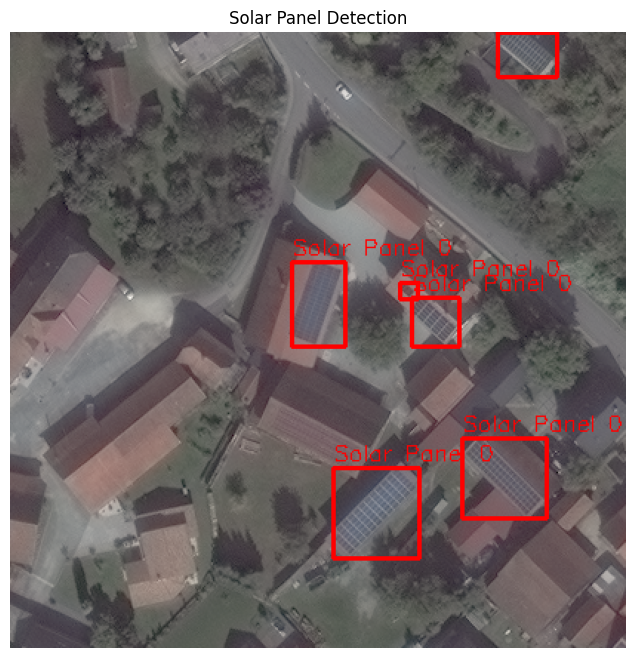

Saved visualized image at /home/rishabh.mondal/AISG_Assignment_1/visualized_bbox.png


In [3]:

# Paths
image_dir = "/home/rishabh.mondal/AISG_Assignment_1/image_chips_native"
label_file = "/home/rishabh.mondal/AISG_Assignment_1/labels/labels_native/solarpanels_native_1__x0_2635_y0_9766_dxdy_416.txt"
image_file = os.path.join(image_dir, "solarpanels_native_1__x0_2635_y0_9766_dxdy_416.tif")  

# Image size and chip offsets
chip_size = 416
x0, y0 = 2635, 9766  # Extracted from filename

# Geotransform for Tile 1
origin_x, pixel_size_x, _, origin_y, _, pixel_size_y = 307670.04, 0.31, 0.0, 5434427.1, 0.0, -0.31

# Transformer for UTM to Lat/Lon
transformer = Transformer.from_crs("EPSG:32633", "EPSG:4326", always_xy=True)

# Read YOLO labels and compute bounding boxes
solar_panels = []
image = cv2.imread(image_file)

if image is None:
    print("Error: Image not found!")
    exit()

# Convert BGR (OpenCV format) to RGB (Matplotlib format)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open(label_file, "r") as f:
    lines = f.readlines()
    for line in lines:
        values = line.strip().split()
        category, x_center, y_center, width, height = map(float, values)

        # Convert YOLO normalized coords to pixel coords
        x_pixel = x_center * chip_size
        y_pixel = y_center * chip_size
        w_px = width * chip_size
        h_px = height * chip_size

        # Convert to absolute pixel position in full tile
        absolute_x = x0 + x_pixel
        absolute_y = y0 + y_pixel

        # Convert to UTM coordinates (center)
        utm_x = origin_x + (absolute_x * pixel_size_x)
        utm_y = origin_y + (absolute_y * pixel_size_y)

        # Convert to UTM bounding box coordinates
        utm_xmin = utm_x - (w_px * pixel_size_x) / 2
        utm_xmax = utm_x + (w_px * pixel_size_x) / 2
        utm_ymin = utm_y - (h_px * pixel_size_y) / 2
        utm_ymax = utm_y + (h_px * pixel_size_y) / 2

        # Convert UTM to Lat/Lon
        lon, lat = transformer.transform(utm_x, utm_y)
        lon_min, lat_min = transformer.transform(utm_xmin, utm_ymin)
        lon_max, lat_max = transformer.transform(utm_xmax, utm_ymax)

        # Store results
        solar_panels.append([
            category, lon, lat, utm_x, utm_y, 
            lon_min, lat_min, lon_max, lat_max, 
            utm_xmin, utm_ymin, utm_xmax, utm_ymax
        ])

        # Compute bounding box corners
        xmin = int(x_pixel - w_px / 2)
        ymin = int(y_pixel - h_px / 2)
        xmax = int(x_pixel + w_px / 2)
        ymax = int(y_pixel + h_px / 2)

        # Draw Bounding Box (Red)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        label = f"Solar Panel {int(category)}"
        cv2.putText(image, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Create DataFrame
df = pd.DataFrame(solar_panels, columns=[
    "Category", "Longitude", "Latitude", "UTM_X", "UTM_Y", 
    "Lon_min", "Lat_min", "Lon_max", "Lat_max", 
    "UTM_Xmin", "UTM_Ymin", "UTM_Xmax", "UTM_Ymax"
])

# Display DataFrame
print(df.head())

# Plot the image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.title("Solar Panel Detection")
plt.show()

# Save Image
output_path = "/home/rishabh.mondal/AISG_Assignment_1/visualized_bbox.png"
cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving
print(f"Saved visualized image at {output_path}")


In [4]:

# Paths
label_dir = "/home/rishabh.mondal/AISG_Assignment_1/labels/labels_native"
chip_size = 416  # YOLO normalization base

# Tile geotransforms
tile_geotransforms = {
    "1": (307670.04, 0.31, 0.0, 5434427.1, 0.0, -0.31),
    "2": (312749.08, 0.31, 0.0, 5403952.86, 0.0, -0.31),
    "3": (312749.08, 0.31, 0.0, 5363320.54, 0.0, -0.31),
}

# UTM to Lat/Lon transformer
transformer = Transformer.from_crs("EPSG:32633", "EPSG:4326", always_xy=True)

solar_panels = []

# Process all label files
for filename in os.listdir(label_dir):
    if filename.endswith(".txt"):
        match = re.search(r"solarpanels_native_(\d)__x0_(\d+)_y0_(\d+)_dxdy_416.txt", filename)
        # print(match)
        if not match:
            continue
        
        tile, x0, y0 = match.groups()
        # print(tile, x0, y0)
        x0, y0 = int(x0), int(y0)
        geotransform = tile_geotransforms[tile]
        origin_x, pixel_size_x, _, origin_y, _, pixel_size_y = geotransform
        
        with open(os.path.join(label_dir, filename), "r") as f:
            lines = f.readlines()
            for line in lines:
                values = line.strip().split()
                category, x_center, y_center, width, height = map(float, values)
                
                # Convert YOLO normalized coordinates to pixel coordinates
                x_pixel = x_center * chip_size
                y_pixel = y_center * chip_size
                w_px = width * chip_size
                h_px = height * chip_size
                
                # Absolute pixel position in full tile
                absolute_x = x0 + x_pixel
                absolute_y = y0 + y_pixel
                
                # Convert to UTM coordinates (center)
                utm_x = origin_x + (absolute_x * pixel_size_x)
                utm_y = origin_y + (absolute_y * pixel_size_y)
                
                # Convert bounding box UTM coordinates
                utm_xmin = utm_x - (w_px * pixel_size_x) / 2
                utm_xmax = utm_x + (w_px * pixel_size_x) / 2
                utm_ymin = utm_y - (h_px * pixel_size_y) / 2
                utm_ymax = utm_y + (h_px * pixel_size_y) / 2
                
                # Convert UTM to Lat/Lon
                lon, lat = transformer.transform(utm_x, utm_y)
                lon_min, lat_min = transformer.transform(utm_xmin, utm_ymin)
                lon_max, lat_max = transformer.transform(utm_xmax, utm_ymax)
                
                # Store results
                solar_panels.append([
                    category, lon, lat, utm_x, utm_y,
                    lon_min, lat_min, lon_max, lat_max,
                    utm_xmin, utm_ymin, utm_xmax, utm_ymax
                ])

# Create DataFrame
df = pd.DataFrame(solar_panels, columns=[
    "Category", "Longitude", "Latitude", "UTM_X", "UTM_Y", 
    "Lon_min", "Lat_min", "Lon_max", "Lat_max", 
    "UTM_Xmin", "UTM_Ymin", "UTM_Xmax", "UTM_Ymax"
])

# Save DataFrame
df.to_csv("/home/rishabh.mondal/AISG_Assignment_1/solar_panels_geo.csv", index=False)
print("Saved DataFrame to solar_panels_geo.csv")
print(df.head())




Saved DataFrame to solar_panels_geo.csv
   Category  Longitude   Latitude       UTM_X        UTM_Y    Lon_min  \
0       0.0  12.380258  49.012842  308443.955  5432190.140  12.380214   
1       0.0  12.380184  49.012710  308438.065  5432175.725  12.380093   
2       0.0  12.379625  49.012622  308396.835  5432167.355  12.379596   
3       0.0  12.379567  49.012622  308392.650  5432167.510  12.379549   
4       0.0  12.379497  49.012640  308387.535  5432169.680  12.379463   

     Lat_min    Lon_max    Lat_max   UTM_Xmin    UTM_Ymin   UTM_Xmax  \
0  49.012905  12.380301  49.012779  308441.01  5432197.27  308446.90   
1  49.012788  12.380275  49.012633  308431.71  5432184.56  308444.42   
2  49.012651  12.379654  49.012594  308394.82  5432170.61  308398.85   
3  49.012642  12.379585  49.012603  308391.41  5432169.68  308393.89   
4  49.012668  12.379530  49.012613  308385.21  5432172.78  308389.86   

     UTM_Ymax  
0  5432183.01  
1  5432166.89  
2  5432164.10  
3  5432165.34  
4  54321

In [5]:
from shapely.geometry import Point
import geopandas as gpd

# Load the DataFrame (assuming it is already created)
df = pd.read_csv("solar_panels_geo.csv")  # Update with the actual file path

# Calculate center coordinates (mean of latitudes & longitudes)
latitudes = df["Latitude"]
longitudes = df["Longitude"]
 

# save the center coordinates in geopandas dataframe
# Create GeoPandas DataFrame
geometry = [Point(lon, lat) for lon, lat in zip(longitudes, latitudes)]

gdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")  # WGS84 Lat/Lon

# Save as GeoJSON
gdf.to_file("solar_panels_centers.geojson", driver="GeoJSON")





In [6]:
# coords= df[['Longitude', 'Latitude']].values
# print(coords[0])
# l=coords[0]

In [8]:
import leafmap
import geopandas as gpd

# Load the saved GeoJSON file
gdf = gpd.read_file("solar_panels_centers.geojson")

# Select the first 1000 points
gdf_subset = gdf.head(1000)

# Save the subset as a temporary GeoJSON file
subset_geojson = "solar_panels_subset.geojson"
gdf_subset.to_file(subset_geojson, driver="GeoJSON")

# Create a Leafmap Map
m = leafmap.Map()
m.add_basemap("SATELLITE")

# Add the first 10 points
m.add_geojson(subset_geojson, layer_name="Solar Panels", radius=5,zoom_to_layer=17)

# Display the map
m



Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…